To train the convolutional spiking neural network, I will use the fast_sigmoid function as replacement to the heavside in the backward pass and train using the surrogate gradient descent. The reason is heavside is non differentiable and we need to differentiability to introduce the learning by propagating the gradients.

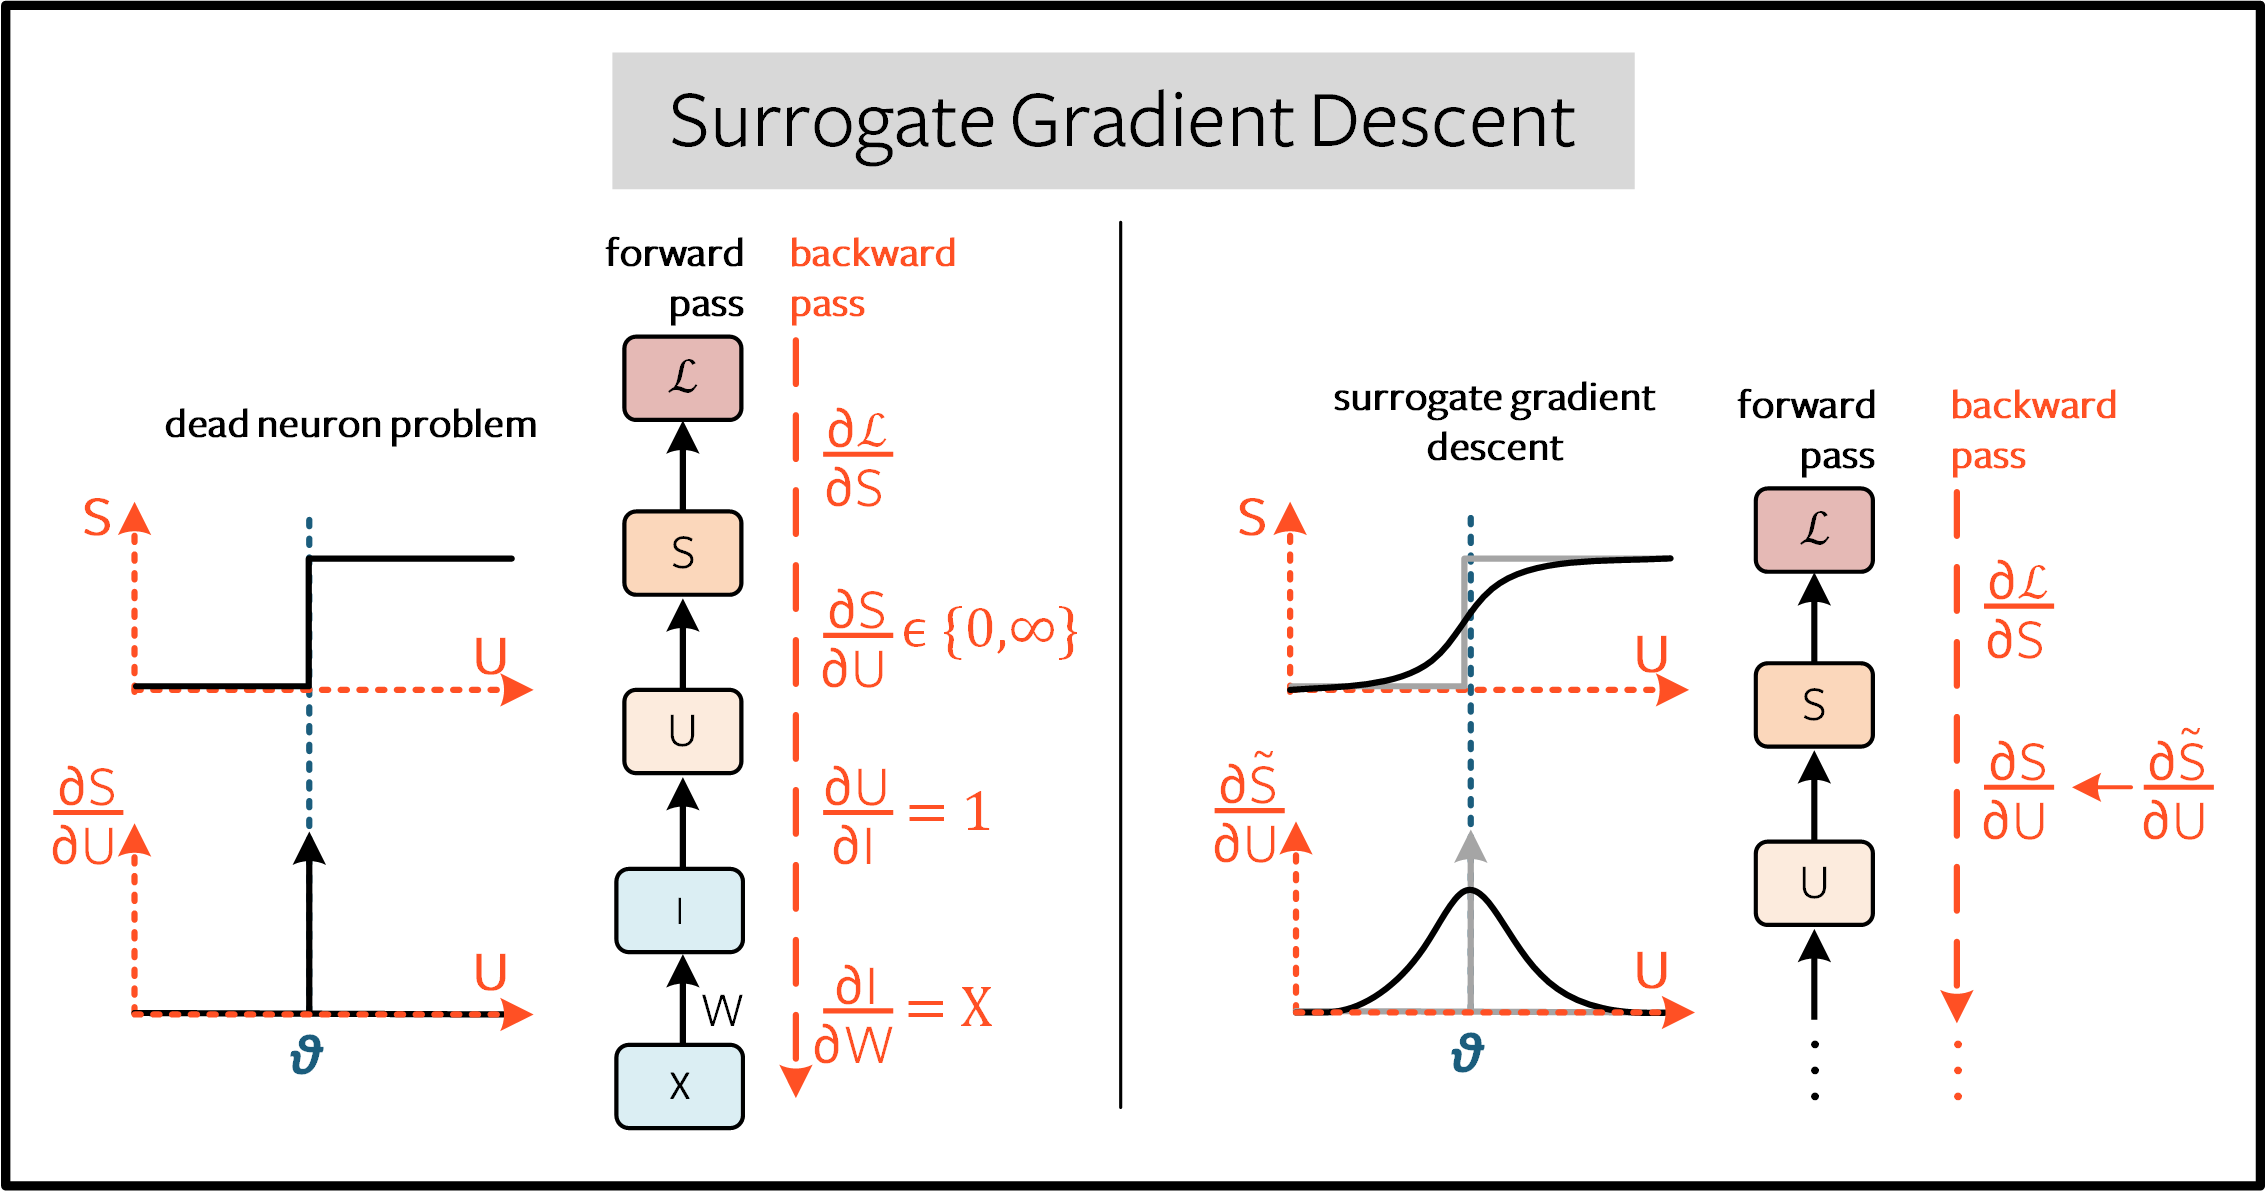

## Necessary Imports

In [1]:
! pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 6.2 MB/s eta 0:00:00


In [2]:

import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

from tqdm import tqdm

<ipython-input-2-01898dd2e133>:3: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


## Creating Dataloaders

In [38]:
# dataloader arguments
batch_size = 512
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

subset_indices = torch.arange(512)
train_sub = Subset(mnist_train, subset_indices)
# Create DataLoaders

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## Defining the Network

In [4]:
class CSNN(nn.Module):
  def __init__(self):
    super().__init__()
    beta = 0.5
    self.num_steps = 50
    spike_grad = surrogate.fast_sigmoid(slope = 25)

    self.network = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    )

  def forward(self, x):
    out_mem = []
    out_spike = []
    utils.reset(self.network)  # resets hidden states for all LIF neurons in net

    for setp in range(self.num_steps):
      spk, mem = self.network(x)    # right now repeatedly same data for all the steps
      out_mem.append(mem)
      out_spike.append(spk)

    return torch.stack(out_spike), torch.stack(out_mem)

### Training the Model

Different from the SNN on convolution we will use rate based cross entropy so rate of spikes in each class will be optimized and thier crossentropy will be back propagated to optimize the model.

I won't use the validation set in the train loop, just to save some time

In [45]:
def train_snn(optimizer, model, train_loader, val_loader, num_epochs = 50):
  loss_hist = []
  test_loss_hist = []
  criterion = SF.ce_rate_loss()   ##loss function
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

  model = model.to(device)

  for epoch in range(num_epochs):

    print(f'Epoch ....... {epoch} / {num_epochs}')

    ## Training the model
    model.train()

    running_loss = 0
    count = 0
    for images, targets in tqdm(train_loader):
      images = images.to(device)
      targets = targets.to(device)

      out_spks, out_mem = model(images)


      loss = criterion(out_spks, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss+=loss.item()

      count+=1

    print('Loss:', running_loss/count)



In [56]:
model = CSNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [57]:
train_snn(optimizer, model, train_loader, '0', num_epochs = 7)

Epoch ....... 0 / 7


100%|██████████| 117/117 [00:43<00:00,  2.69it/s]


Loss: 1.5984709619456887
Epoch ....... 1 / 7


100%|██████████| 117/117 [00:43<00:00,  2.72it/s]


Loss: 1.4869151461837637
Epoch ....... 2 / 7


100%|██████████| 117/117 [00:43<00:00,  2.67it/s]


Loss: 1.4797156071051574
Epoch ....... 3 / 7


100%|██████████| 117/117 [00:44<00:00,  2.64it/s]


Loss: 1.476730176526257
Epoch ....... 4 / 7


100%|██████████| 117/117 [00:43<00:00,  2.69it/s]


Loss: 1.4747458319378715
Epoch ....... 5 / 7


100%|██████████| 117/117 [00:43<00:00,  2.71it/s]


Loss: 1.4734894271589751
Epoch ....... 6 / 7


100%|██████████| 117/117 [00:43<00:00,  2.68it/s]

Loss: 1.4724174992651002


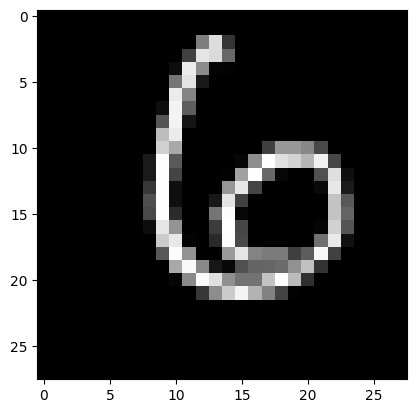

In [58]:
image, target = mnist_test[100]
img = image.squeeze(0)

# Plot the image using matplotlib
plt.imshow(img, cmap='gray')

In [59]:
## model predictions
model.eval()

with torch.no_grad():
  pred_spike, pred_mem = model(image.unsqueeze(0).to(device))
  pred_spike = pred_spike.sum(dim=0)
  _, pred = pred_spike.max(1)

  print(f'Ground truth: {target} \nPrediction: {pred.item()}')

Ground truth: 6 
Prediction: 6


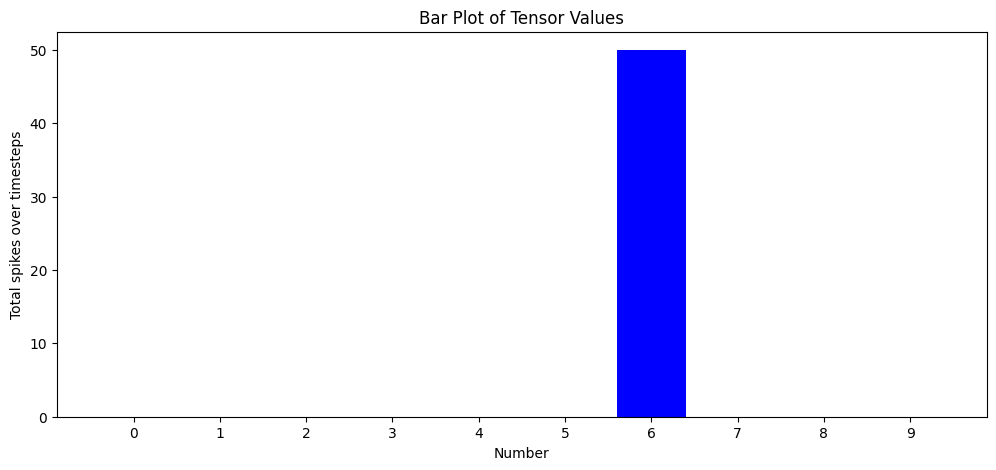

In [60]:
levels = np.arange(0, 10)

# Create the bar plot
plt.figure(figsize=(12, 5))
plt.bar(levels, pred_spike.cpu().numpy().ravel(), color='blue')

# Adding titles and labels
plt.xlabel('Number')
plt.ylabel('Total spikes over timesteps')  #overtime
plt.title('Bar Plot of Tensor Values')
plt.xticks(levels)

# Display the plot
plt.show()

In [61]:
## Measure accuracy on overfit data

def batch_accuracy(train_loader, model):
  with torch.no_grad():
    total = 0
    acc = 0
    model.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = model(data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total


In [62]:
print('Total_accuracy on Validation:', batch_accuracy(test_loader, model)*100)

Total_accuracy on Validation: 98.81784539473685
